In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt1
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import h5py
from PIL import Image
from io import BytesIO
import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(False) # Needed for reproducible results

Random Seed:  999


In [2]:
from sklearn.model_selection import train_test_split,StratifiedKFold
import pickle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from lightgbm import LGBMClassifier

In [3]:
# !kaggle competitions download -c isic-2024-challenge

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
train_matadata = pd.read_csv("../../wgangp/train-metadata.csv", low_memory=False)
train_matadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [10]:
class ImageLoader(Dataset):
    def __init__(self, df, file_hdf, transform=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        # print(isic_id)
        image = Image.open(BytesIO(self.fp_hdf[isic_id][()]))
        target = self.targets[index]
#         image = torch.permute(image,(2,1,0))
        if self.transform:
            return self.transform(image),target
        else:
            return (image),target

In [11]:
train_transforms = transforms.Compose([
                               transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_dataset_full = ImageLoader(train_matadata,
                      file_hdf = "../../wgangp/train-image.hdf5",
                      transform=train_transforms
                     )

dataloader = torch.utils.data.DataLoader(train_dataset_full, batch_size=128,num_workers=6,shuffle=True)


In [12]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self,latent_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (3, 156, 156) -> (64, 78, 78)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (64, 78, 78) -> (128, 39, 39)
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # (128, 39, 39) -> (256, 20, 20)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (128, 39, 39) -> (256, 20, 20)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 39, 39) -> (256, 20, 20)
            nn.ReLU(True),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(128 * 16 , latent_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [13]:
model = Autoencoder(latent_dim=256).cuda()
model.load_state_dict(torch.load('min_loss_autoencoder.pth'),strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['linear.0.weight', 'linear.0.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias', 'decoder.8.weight', 'decoder.8.bias'])

In [14]:
image_latent = []
label = []
for img,y in tqdm.tqdm(dataloader):
        img = img.cuda()
        # Forward pass
        out1 = model(img)
        image_latent.append(out1.cpu().detach().numpy())
        label.append(y.cpu().detach().numpy())

  0%|          | 0/3134 [00:00<?, ?it/s]

 51%|█████     | 1586/3134 [05:12<03:54,  6.61it/s]

In [ ]:
image_latent = np.concatenate( image_latent, axis=0 )
label = np.concatenate( label, axis=0 )

In [ ]:
with open('image_latent_labels2.npy', 'wb') as f:
    np.save(f, image_latent)
    np.save(f, label)

NameError: name 'image_latent' is not defined

In [ ]:
with open('image_latent_labels.npy', 'rb') as f:
    image_latent = np.load(f)
    label = np.load(f)

ValueError: Cannot load file containing pickled data when allow_pickle=False

### MOdelling

#### 1. SVM

In [11]:
X_train, X_test, y_train, y_test = train_test_split(image_latent, label,stratify=label,test_size=0.5,random_state=99)

In [12]:
from sklearn.svm import SVC
clf1 = SVC(class_weight={1: 100},probability=True).fit(X_train,y_train)

In [14]:
import pickle

In [15]:
with open('svm_classify_AUTOENCODER.pkl','wb') as f:
    pickle.dump(clf1,f)

In [16]:
y_pred = clf1.predict_proba(X_test)

/data1/home/nidhi2023/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


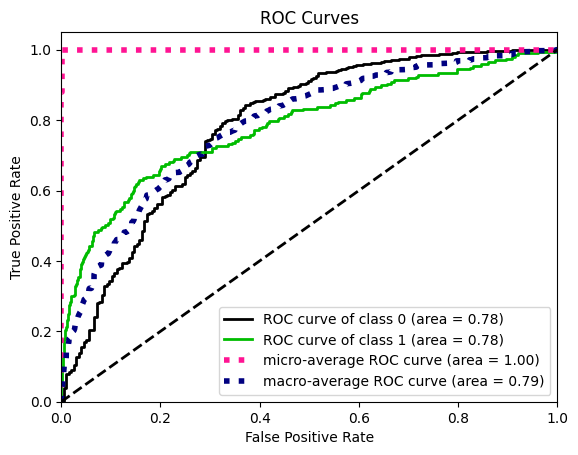

In [17]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

In [31]:
def score(solution, submission, min_tpr: float=0.80) -> float:
    print(solution.shape,submission.shape)
    v_gt = abs(np.asarray(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

In [32]:
y_pred[:,0].shape

NameError: name 'y_pred' is not defined

In [35]:
score(y_test,y_pred[:,1])

0.06336151830045611

#### 2. Decision Tree

In [39]:
def pauc_above_tpr(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [42]:
def Train_ML(Model, X, y):
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=99)
    train_scores = []
    val_scores = []
    test_predictions = [] 
    models = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):

        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        model = Model
        
        model.fit(X_train, y_train)

        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
        train_pauc = pauc_above_tpr(y_train,pd.DataFrame(y_train_pred_proba, columns=["prediction"]),min_tpr=0.8)
        train_scores.append(train_pauc)

        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        val_pauc = pauc_above_tpr(y_val,pd.DataFrame(y_val_pred_proba, columns=["prediction"]),min_tpr=0.8)
        val_scores.append(val_pauc)
        
        # y_test_pred_proba = model.predict_proba(test)[:, 1]
        # test_predictions.append(y_test_pred_proba)
        
        models.append(model)

        print(f"Fold {fold}: Train pAUC = {train_pauc:.4f}, Validation pAUC = {val_pauc:.4f}")

    mean_train_pauc = np.mean(train_scores)
    mean_val_pauc = np.mean(val_scores)

    print(f"\nMean Train pAUC: {mean_train_pauc:.4f}")
    print(f"Mean Validation pAUC: {mean_val_pauc:.4f}")

    return model,test_predictions, models

In [43]:
# %%time

params =  {
        'objective': 'binary', 'colsample_bytree': 0.6852015051268027, 'max_depth': 4, 
        'learning_rate': 0.05714390301637632, 'n_estimators': 1010, 'subsample': 0.13326633837138008, 
        'lambda_l1': 1.4445754309498806e-08, 'lambda_l2': 0.11031259304642657, 'boosting_type': 'dart'
            }

Model = LGBMClassifier(**params,verbose=-1,random_state=99,
                      extra_tree=True,max_bin=250,reg_alpha=0.1,reg_lambda=0.8
                      )

train_lgb, test_preds , all_models = Train_ML(Model, image_latent, label)

Fold 1: Train pAUC = 0.1971, Validation pAUC = 0.1141
Fold 2: Train pAUC = 0.1962, Validation pAUC = 0.1165
Fold 3: Train pAUC = 0.1971, Validation pAUC = 0.1135

Mean Train pAUC: 0.1968
Mean Validation pAUC: 0.1147
